In [1030]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Exercise 3

### Question A

In [1031]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [1032]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


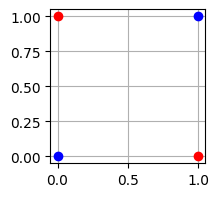

In [1033]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()

plt.show()

In [1034]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, one_hot=False, activation_function='sigmoid'):
        # Initialize number of nodes of input, hidden, and output layer
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Use of one_hot encoding
        self.one_hot = one_hot

        # Activation function
        self.activation_function = activation_function

        # Initialize weights (w) and biases (b)
        # input -> hidden
        self.w1 = np.random.rand(self.input_size, self.hidden_size) # 35*10
        self.b1 = np.zeros((1, self.hidden_size)) # 1*10

        # hidden -> output
        self.w2 = np.random.rand(self.hidden_size, self.output_size) # 10*1
        self.b2 = np.zeros((1, self.output_size)) # 1*1

        # Record data
        self.losses = []

    def activation(self, x, activation_function, deriv=False):
        """Activation function (sigmoid, reLU)"""
        if activation_function == 'sigmoid':
            if deriv:
                return self.activation(x, activation_function) * (1 - self.activation(x, activation_function))
            return 1 / (1 + np.exp(-x))
        elif activation_function == 'relu':
            return np.maximum(0, x)
        

    def one_hot_encoding(self, y):
        """Encode digit to one-hot (used in error calculation of backpropagation)"""
        y = y.reshape(-1, 10)
        encoded_y = np.zeros((y.size, y.max() + 1))
        encoded_y[np.arange(y.size), y.flatten()] = 1
        encoded_y = encoded_y.T
        return encoded_y

    def feedforward(self, x):
        """Feedforward"""
        # input -> hidden
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(self.z1, 'sigmoid')

        # hidden -> output
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.activation(self.z2, 'sigmoid')

        return self.a2

    def backpropagation(self, x, y, learning_rate):
        """Backpropagation"""        
        self.m = y.size
        
        self.d_z2 = self.a2 - y # 10*1
        self.d_w2 = np.dot(self.a1.T, self.d_z2) / self.m
        self.d_b2 = np.sum(self.d_z2) / self.m # 1*1
        
        self.d_z1 = np.dot(self.d_z2, self.w2.T) * self.activation(self.z1, self.activation_function, deriv=True)
        self.d_w1 = np.dot(x.T, self.d_z1) / self.m
        self.d_b1 = np.sum(self.d_z1) / self.m

        self.w1 -= self.d_w1 * learning_rate
        self.b1 -= self.d_b1 * learning_rate
        self.w2 -= self.d_w2 * learning_rate
        self.b2 -= self.d_b2 * learning_rate

    def train(self, x, y, learning_rate, epochs):
        """Optimize weight and bias parameters""" 
        self.input = x
        self.output = y
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        if self.one_hot:
            y = self.one_hot_encoding(y)
        
        for epoch in range(epochs):
            self.feedforward(x)
            self.backpropagation(x, y, learning_rate)

            loss = np.mean(np.square(y - self.a2))
            self.losses.append(loss)

            if not epoch % (epochs / 10):
                print(f'Epoch {epoch}: {loss}')

    def predict(self, x):
        """Get network output with current parameters"""
        prediction = self.feedforward(x)
        if self.output_size == 1:
            return (prediction > 0.5).astype(int)
        return self.output[np.argmax(prediction, axis=1)]

    def graph(self, graph_type, name=None, xlim=None):
        """Graph information about neural network performance"""
        
        # Check graph type
        if graph_type == None:
            raise ValueError('Unknown graph type')
        
        # Generate name if no name is given
        if name == None:
            name = datetime.now().strftime('%Y_%m_%d_%H_%M_%S_%f')

        # Add parameter box for plot
        parameters = (
            'Parameters\n\n'
            f'Input nodes: {self.input_size}\n'
            f'Hidden nodes: {self.hidden_size}\n'
            f'Output nodes: {self.output_size}\n'
            f'Learning rate: {self.learning_rate}\n'
            f'Epochs: {self.epochs}'
        )
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 1]}, figsize=(7.2, 4.8))
        ax2.text(-0.2, 0.7, parameters, bbox=dict(facecolor='white', alpha=0.5), transform=ax2.transAxes)
        ax2.axis('off')

        # Set x-axis limits
        if xlim != None:
            ax1.set_xlim(xlim)

        # Plot loss vs epoch
        if graph_type == 'loss_epoch':
            ax1.plot(self.losses)            
            ax1.set_title('Loss vs epoch')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.grid()
            fig.savefig(f'./graphs/loss_{name}', dpi=300)

        # Plot confusion matrix
        elif graph_type == 'confusion':
            matrix = np.array([self.feedforward(value).squeeze() for value in self.input]).T      
            im = ax1.matshow(matrix, cmap='viridis');

            for i in range(matrix.shape[0]):                
                for j in range(matrix.shape[1]):
                    ax1.text(j, i, f'{np.round(matrix[i, j], 2)}', ha='center', va='center', color='white', size='8')

            ax1.set_title('Confusion matrix')
            ax1.set_xlabel('Predicted digit')
            ax1.set_ylabel('Real digit')
            ax1.set_xticks(np.arange(len(self.input)))
            ax1.set_yticks(np.arange(len(self.input)))
            fig.colorbar(im, ax=ax1)
            fig.savefig(f'./graphs/confusion_{name}', dpi=300);

In [1035]:
learning_rate = 0.1
epochs = 10000
nn_A = NeuralNetwork(2, 2, 1)
nn_A.train(x, y, learning_rate, epochs)
nn_A.predict(x)

Epoch 0: 0.2809525163238922
Epoch 1000: 0.24998832899753715
Epoch 2000: 0.2499474256809005
Epoch 3000: 0.24984830957790227
Epoch 4000: 0.24942226549591673
Epoch 5000: 0.245780175428162
Epoch 6000: 0.21957372394555735
Epoch 7000: 0.18384472594729218
Epoch 8000: 0.16931952171434694
Epoch 9000: 0.1595726960626188


array([[0],
       [1],
       [1],
       [1]])

### Question B

Load raw data

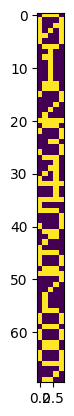

In [1036]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [1037]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

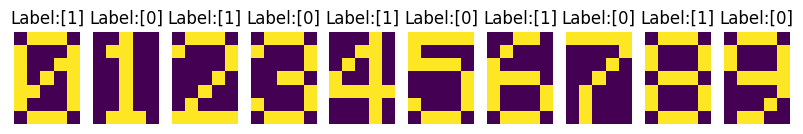

In [1038]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [1039]:
input_size = 35
hidden_size = 10
output_size = 1

learning_rate = 0.1
epochs = 10000

nn_B = NeuralNetwork(input_size, hidden_size, output_size)
nn_B.train(x, y, learning_rate, epochs)
nn_B.predict(x)

Epoch 0: 0.4934154114688358
Epoch 1000: 0.2403132699339105
Epoch 2000: 0.006215126886721421
Epoch 3000: 0.0005986388185419735
Epoch 4000: 0.00017227997006717945
Epoch 5000: 7.71022809391658e-05
Epoch 6000: 4.281641883772634e-05
Epoch 7000: 2.6985288589436277e-05
Epoch 8000: 1.8473284765822055e-05
Epoch 9000: 1.3401248937441206e-05


array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

digit is even: [[0]]


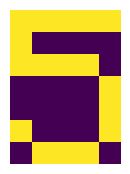

In [1040]:
digit = 5

plt.figure(figsize=(2,2))
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
plt.axis('off')
res = nn_B.predict(data_flattened[digit])
print('digit is even:', res)

### Exercise C

Initialize data
- x: 10*35 (10 digits * 35 pixels each)
- y: 10*1 (can be classified to 10 possible digits)

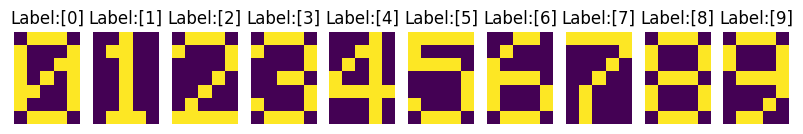

In [1041]:
x = data_flattened
y = np.arange(10).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [1042]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.1
epochs = 100000

nn_C = NeuralNetwork(input_size, hidden_size, output_size, one_hot=True, activation_function='sigmoid')
nn_C.train(x, y, learning_rate, epochs)
nn_C.predict(x)

Epoch 0: 0.8700688724239469
Epoch 10000: 0.08488077940763417
Epoch 20000: 0.054886010642201645
Epoch 30000: 0.036575434667120384
Epoch 40000: 0.014827538427193532
Epoch 50000: 0.006121728434660811
Epoch 60000: 0.003255596809724269
Epoch 70000: 0.0020076502353447716
Epoch 80000: 0.0013608021148411298
Epoch 90000: 0.0009838433360400117


array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

digit is: [[7]]


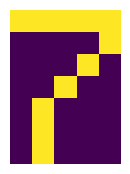

In [1043]:
digit = 7

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_C.predict(data_flattened[digit])
print('digit is:', res)

In [1044]:
def salt_pepper_noise(img, salt_probability, pepper_probability):
    img_copy = np.copy(img)
    salt = np.random.rand(img.size) < salt_probability
    pepper = np.random.rand(img.size) < pepper_probability
    img_copy[salt] = 1
    img_copy[pepper] = 0
    return img_copy

def random_noise(img):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.rand(img_copy.size)
    return img_copy

def gaussian_noise(img, mean, std):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.normal(mean, std, img_copy.size)
    return img_copy

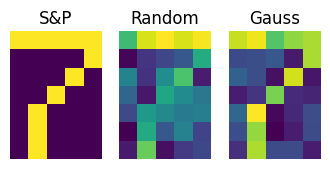

In [1045]:
salt_pepper_digit = salt_pepper_noise(data_flattened[digit], 0.05, 0.05)
random_digit = random_noise(data_flattened[digit])
gauss_digit = gaussian_noise(data_flattened[digit], 0.1, 0.1)

noised_data = [salt_pepper_digit, random_digit, gauss_digit]
titles = ['S&P', 'Random', 'Gauss']

plt.figure(figsize=(4,3))
for i, img in enumerate(noised_data):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)));

In [1046]:
nn_C.predict(random_digit)

array([[7]])

# Analysis / graphs

## 3a

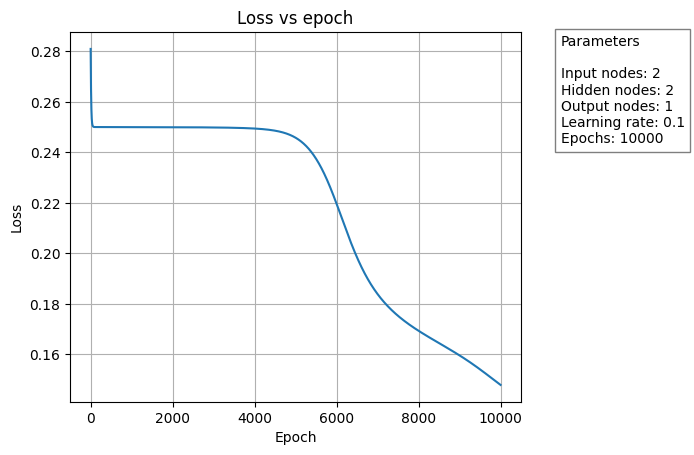

In [1051]:
nn_A.graph('loss_epoch')

## 3b

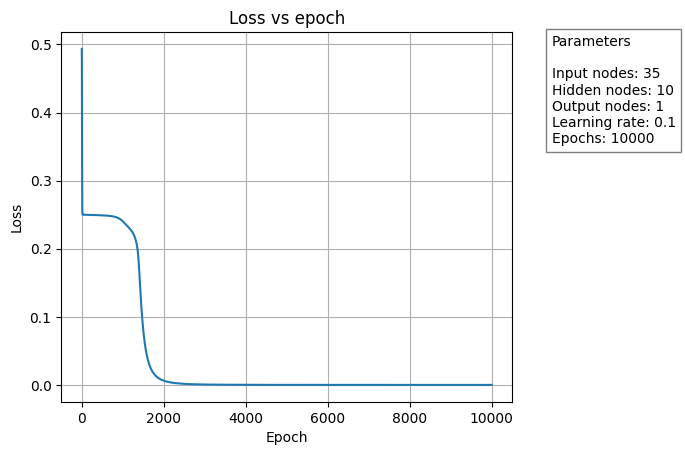

In [1052]:
nn_B.graph(graph_type='loss_epoch')

## 3c

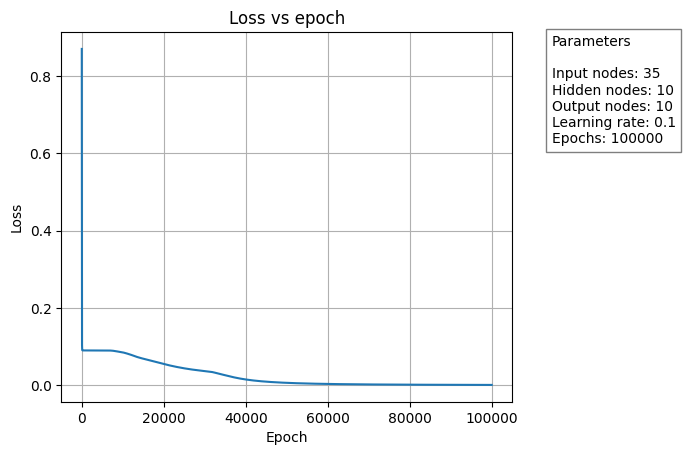

In [1053]:
nn_C.graph('loss_epoch')

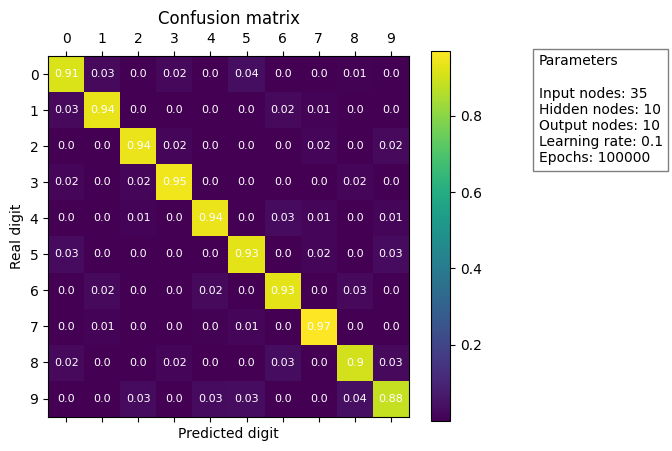

In [1054]:
nn_C.graph(graph_type='confusion')